# Comparison: Year 2007, Old: 201905 New:201905r

In [1]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [3]:
year = '2007'
olddir = '201905'
newdir = 'v201905r/'

In [4]:
def surface_plots(tracers, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=False, olddir=olddir, d201905=False, zoom=[0, 0, 0, 0], dl=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 7))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
            f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')

    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    if twoD:
        mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0, 0])
    else:
        mean_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask[0, dl])
    colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0].set_title(olddir)
    fig.colorbar(colours, ax=axs[0])
    
    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]
    
    if twoD:
        field = np.ma.array(ds[tracer][0], mask=1-tmask[0,0])
    else:
        field = np.ma.array(ds[tracer][0, dl], mask=1-tmask[0, dl])
    colours = axs[1].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title(newdir)
    fig.colorbar(colours, ax=axs[1])
    
    colours = axs[2].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
    axs[2].set_title("New - Old")
    fig.colorbar(colours, ax=axs[2])
    ds.close()
    dm.close()

    for ax in axs:
        viz_tools.set_aspect(ax)
        if sum(zoom) > 0:
            ax.set_ylim(zoom[0], zoom[1])
            ax.set_xlim(zoom[2], zoom[3])

    return fig

In [5]:
def profiles(tracers, file, olddir=olddir, d201905=False, dosum=False):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    
    mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0])
    axs[0].plot(mean_field.mean(axis=1).mean(axis=1), deptht, linewidth=2, label='Old')
    axs[1].plot(np.zeros_like(deptht), deptht, linewidth=2, label='Old')
    
    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.ma.array(ds[tracer][0], mask=1-tmask[0])
    axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label='New')
    
    axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, label='New')
    print (mean_field.mean(axis=1).mean(axis=1).max(), field.mean(axis=1).mean(axis=1).max())
    ds.close()
    dm.close()

    
    axs[0].invert_yaxis()
    axs[0].legend(loc='best')
    
    axs[1].invert_yaxis()
    axs[1].legend(loc='best')
    
    return fig

In [6]:
def thalweg_plots(tracers, file, cmap, cdiff, vmax, vmin, dvmax, olddir=olddir, d201905=False, maxdepth=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
        
    mean_field = np.array(dm[tracer][0])
    colours = vis.contour_thalweg(axs[0], mean_field, bathy, mesh, np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)
    axs[0].set_title(olddir)

    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.array(ds[tracer][0])
    colours = vis.contour_thalweg(axs[1], field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)

    axs[1].set_title(newdir)
    colours = vis.contour_thalweg(axs[2], field-mean_field, bathy, mesh, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                      cmap=cdiff)
 
    axs[2].set_title('New - Old')
    if maxdepth > 0:
        for ax in axs:
            ax.set_ylim(maxdepth, 0)
    ds.close()
    dm.close()

    fig.tight_layout()
    return fig

### January Temperature ###

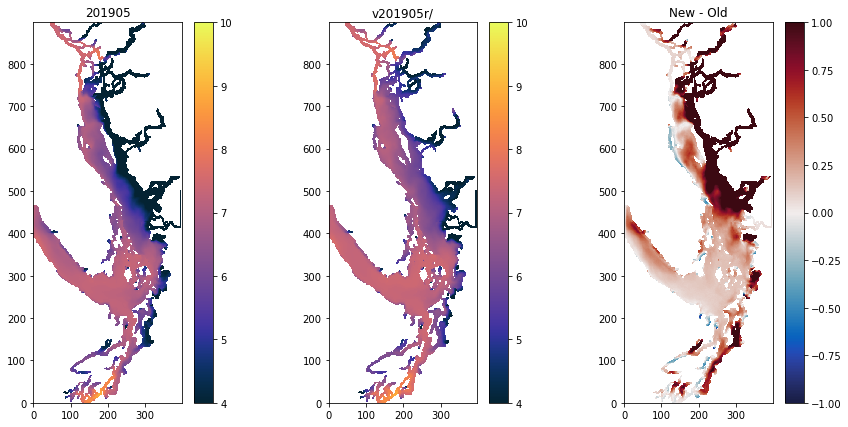

In [7]:
tracer = 'votemper'
file = 'grid'
month = '01'
cmap = cm.thermal
cdiff = cm.balance
vmax = 10
vmin = 4
dvmax = 1 
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

9.152909044758568 9.190618580231943


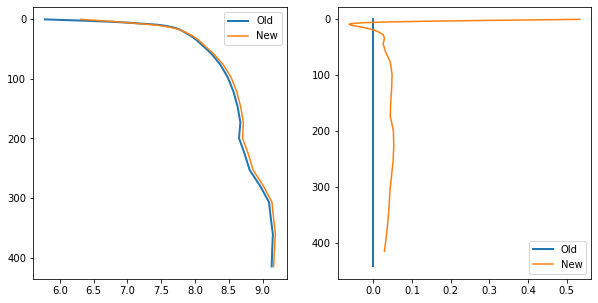

In [8]:
fig = profiles(tracer, file, d201905=True)

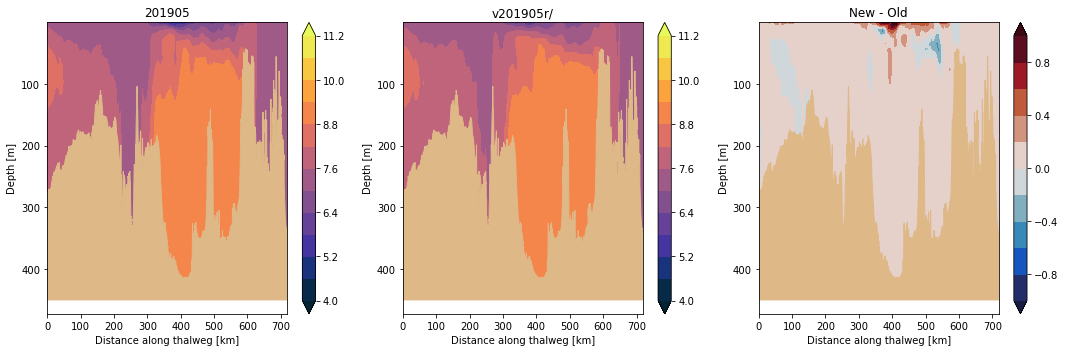

In [9]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### February Nitrate ###

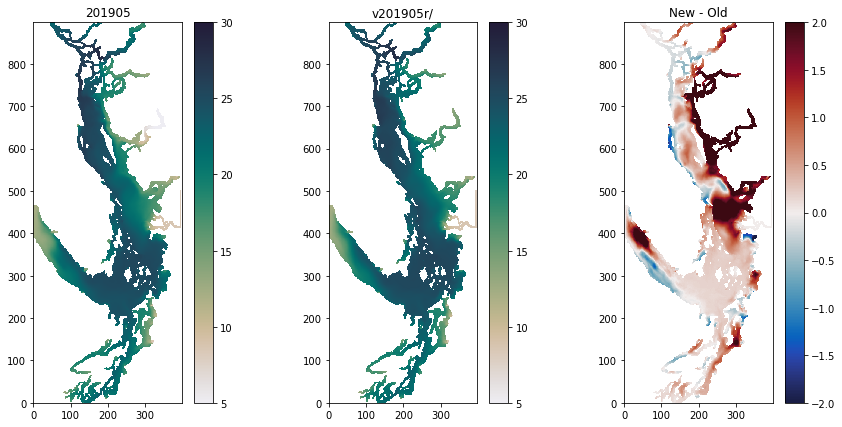

In [10]:
tracer = 'nitrate'
file = 'ptrc'
month = '02'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 5
dvmax = 2  
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

30.036148727587797 30.299518582726144


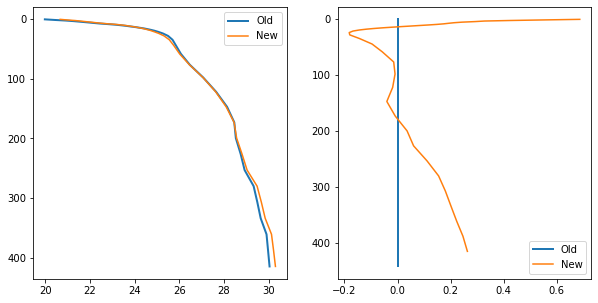

In [11]:
fig = profiles(tracer, file, d201905=True)

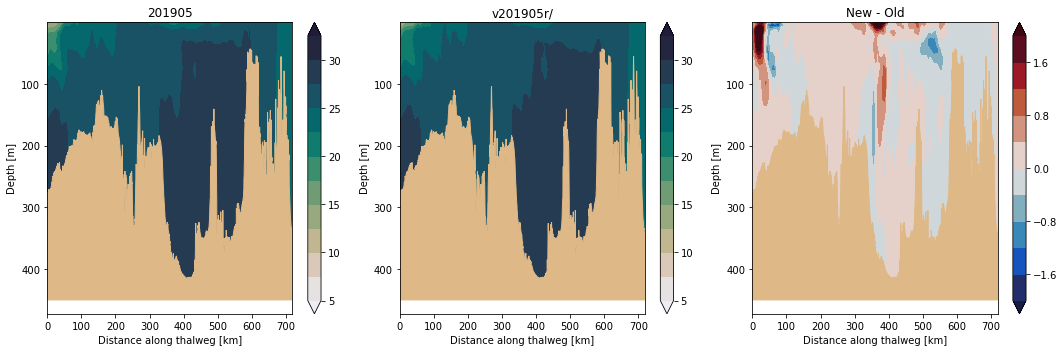

In [12]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### March Diatoms ###

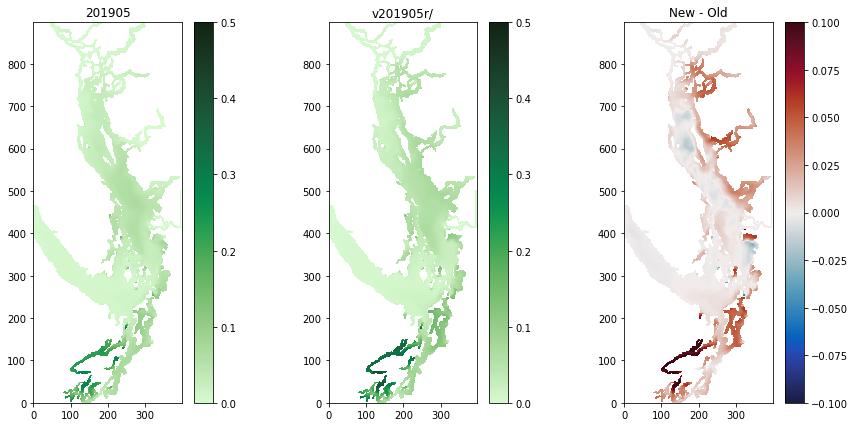

In [16]:
tracer = 'diatoms'
file = 'ptrc'
month = '03'
cmap = cm.algae
cdiff = cm.balance
vmax = 0.5
vmin = 0
dvmax = 0.1 # halved
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)


0.03135804704290736 0.03940856191368964


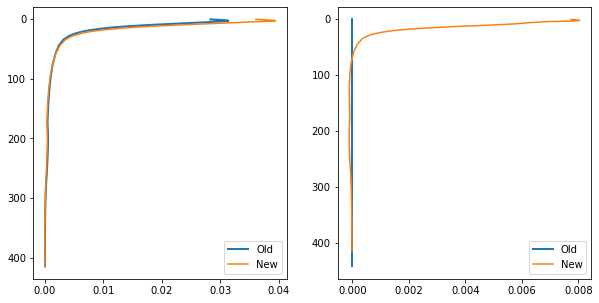

In [17]:
fig = profiles(tracer, file, d201905=True)

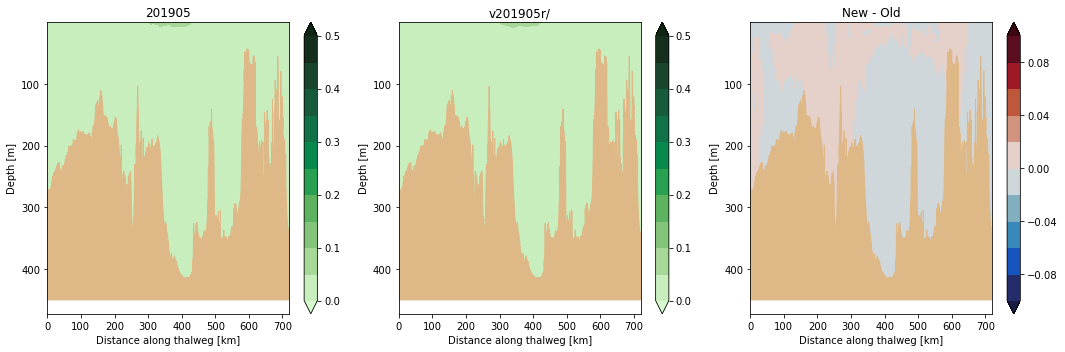

In [18]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### April Microzooplankton ###

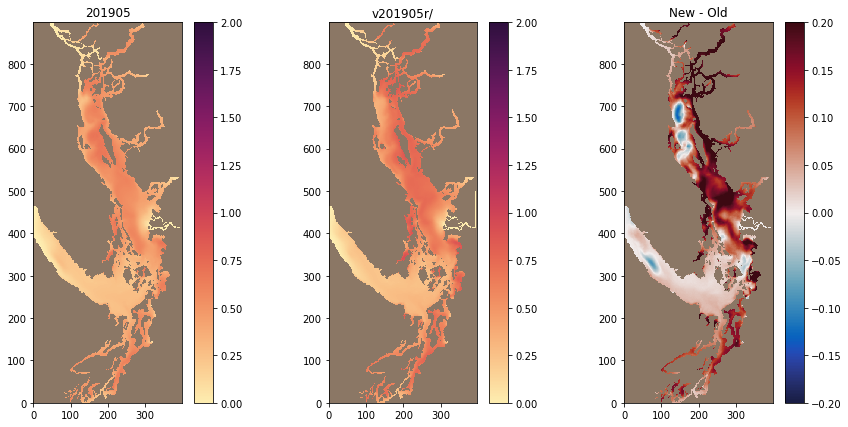

In [55]:
tracer = 'microzooplankton'
file = 'ptrc'
month = '04'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 2
vmin = 0
dvmax = 0.2   # 40%
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

0.3393219187294804 0.40760750315784294


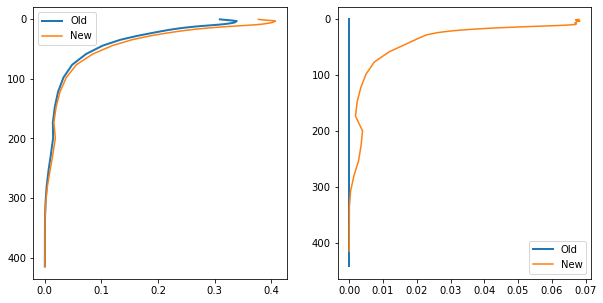

In [56]:
fig = profiles(tracer, file, d201905=True)

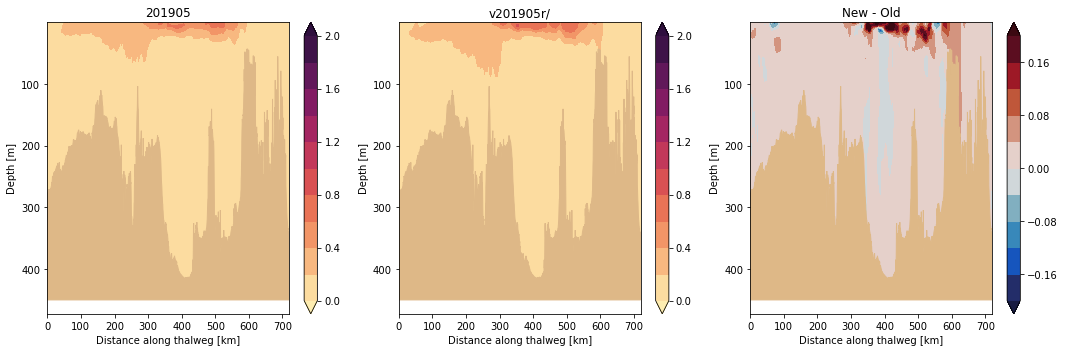

In [57]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### May Salinity ###

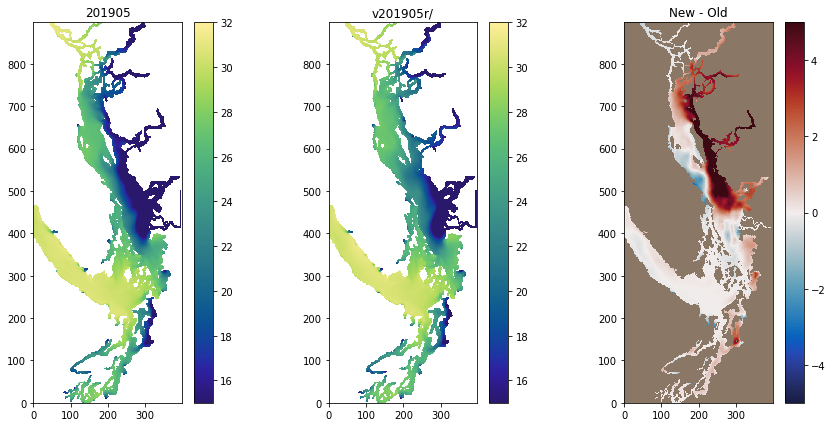

In [58]:
tracer = 'vosaline'
file = 'grid'
month = '05'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 15
dvmax = 5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

31.917363634118413 31.908631908084374


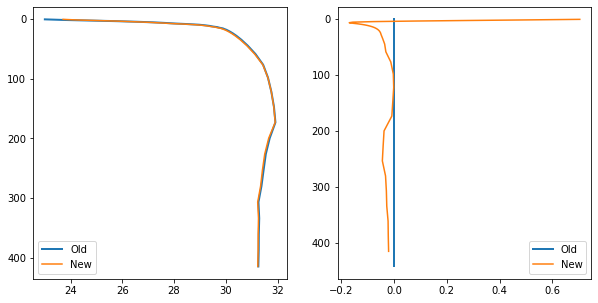

In [59]:
fig = profiles(tracer, file, d201905=True)

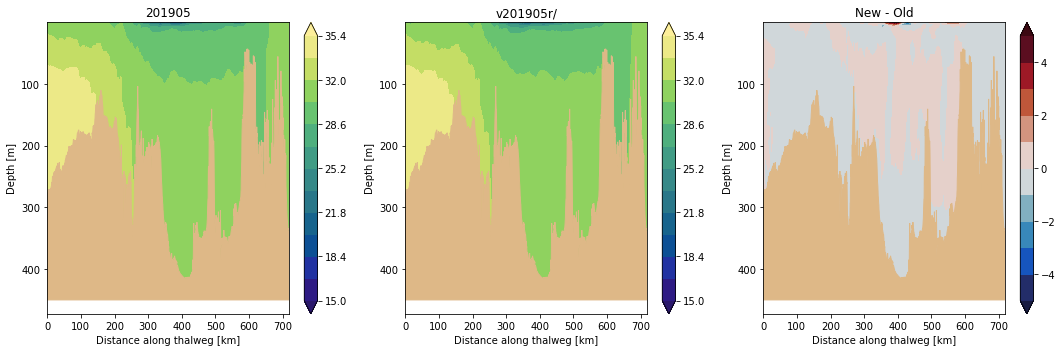

In [60]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### June Flagellates ###


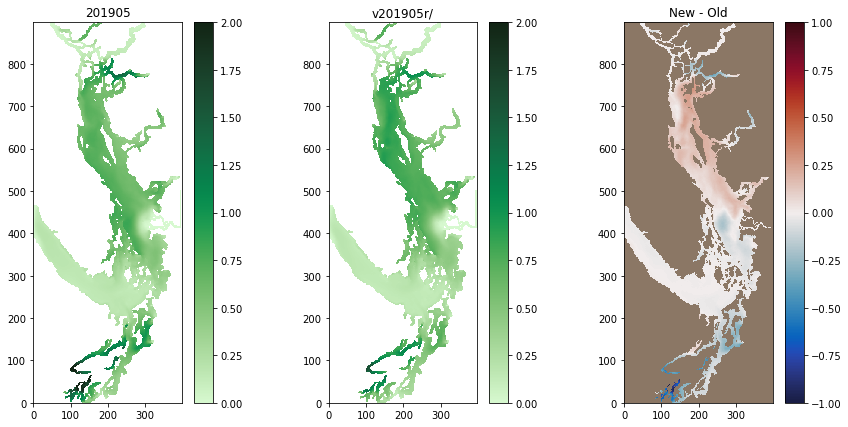

In [61]:
tracer = 'flagellates'
file = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 1   # 50%
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

0.420262683932121 0.42348358208805104


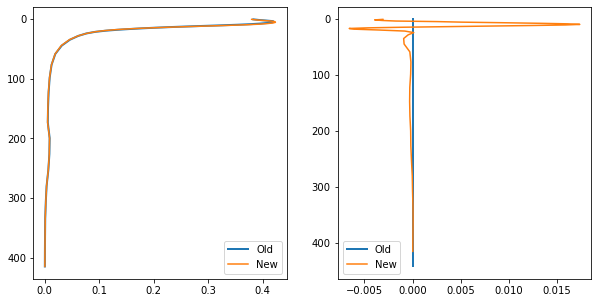

In [62]:
fig = profiles(tracer, file, d201905=True)

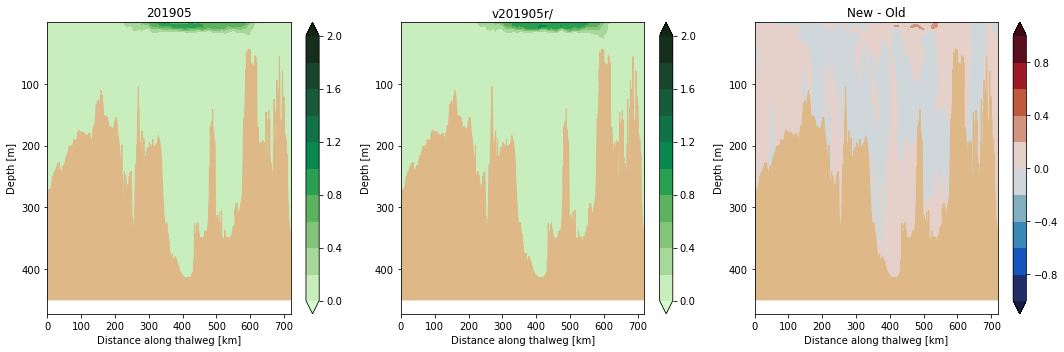

In [63]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### July NH4 ###

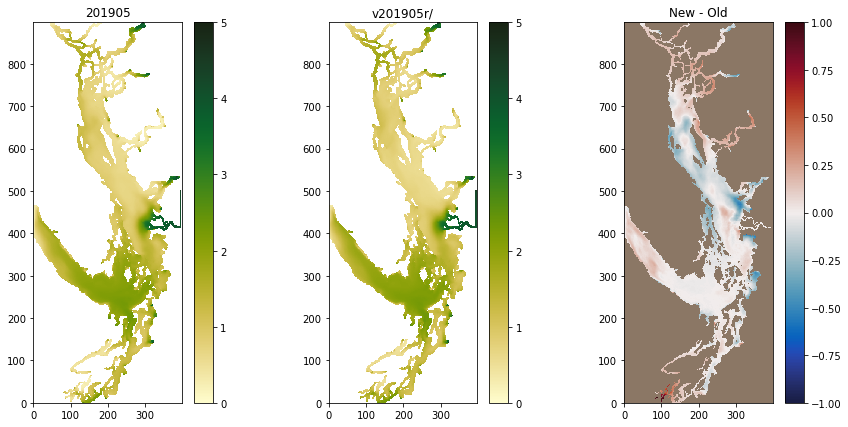

In [64]:
tracer = 'ammonium'
file = 'ptrc'
month = '07'
cmap = cm.speed
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 1  # 50%
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

2.1192925543506766 2.142692710164429


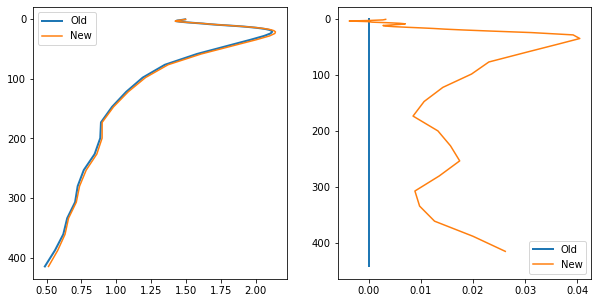

In [65]:
fig = profiles(tracer, file, d201905=True)

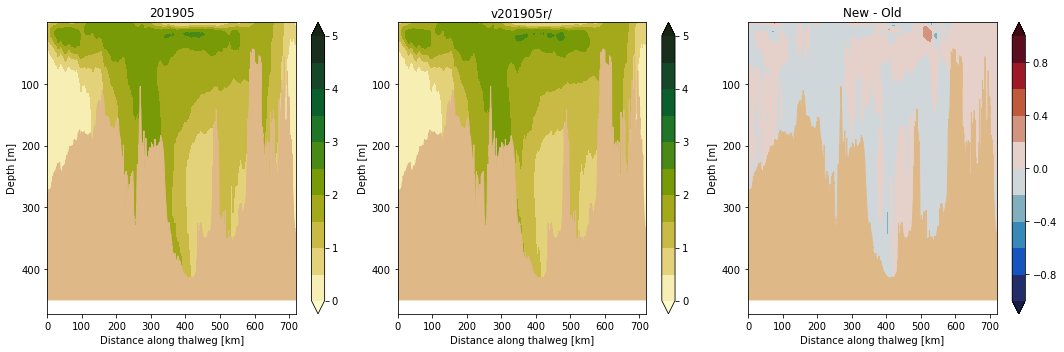

In [66]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### August SSH ###

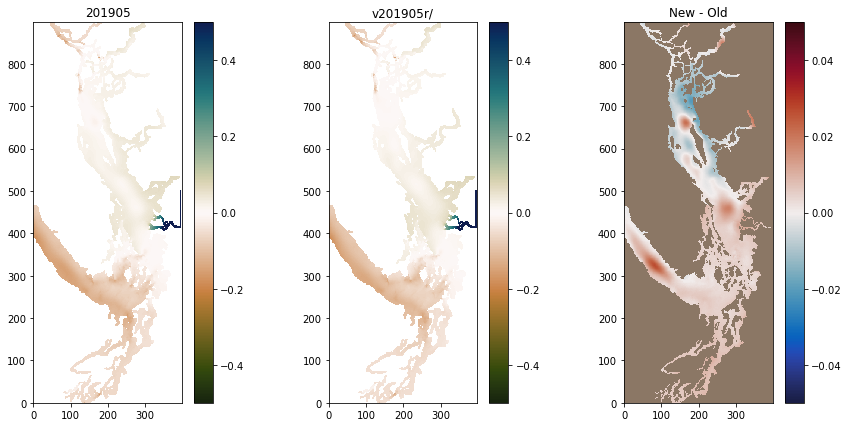

In [69]:
tracer = 'sossheig'
file = 'grid'
month = '08'
cmap = cm.tarn
cdiff = cm.balance
vmax = 0.5
vmin = -0.5
dvmax = 0.05
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=True, d201905=True)

### Oxygen ###

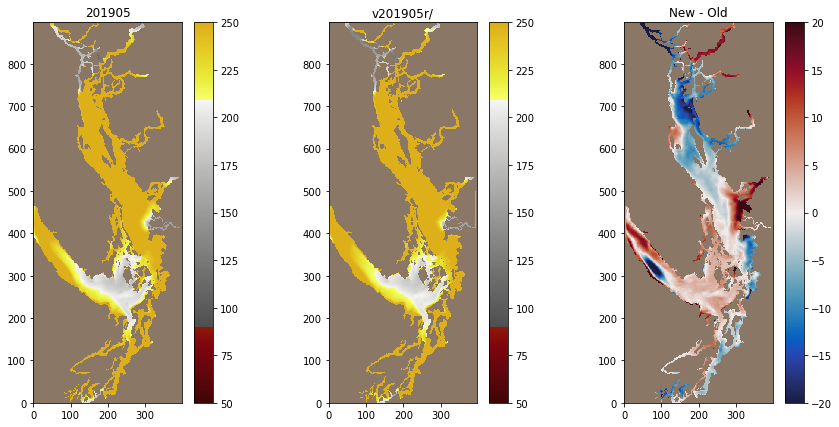

In [70]:
tracer = 'dissolved_oxygen'
file = 'carp'
month = '08'
cmap = cm.oxy
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 250
vmin = 50
dvmax = 20  # 40%
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

248.84019536594414 248.2701392228976


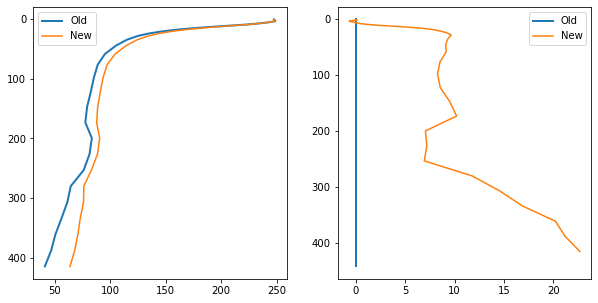

In [71]:
fig = profiles(tracer, file, d201905=True)

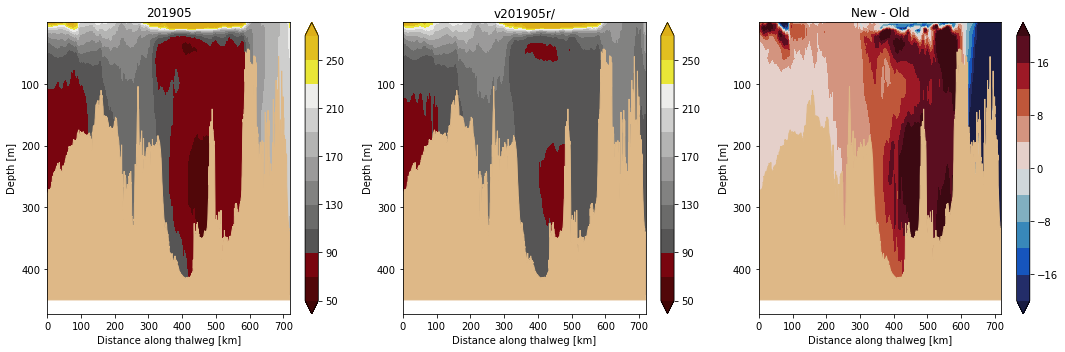

In [72]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

## Oxygen 202111 versus 201905, are we seeing the same changes? ##

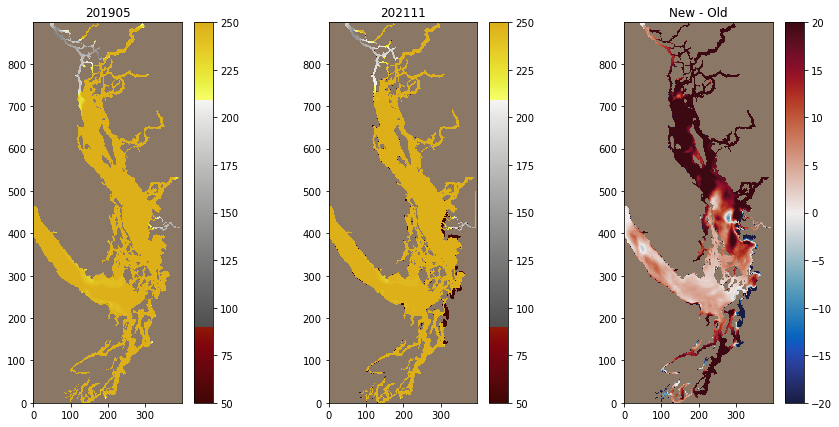

In [74]:
newdir = '202111'
month = '03'
year = 2018
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

282.5268698076223 288.78075098302236


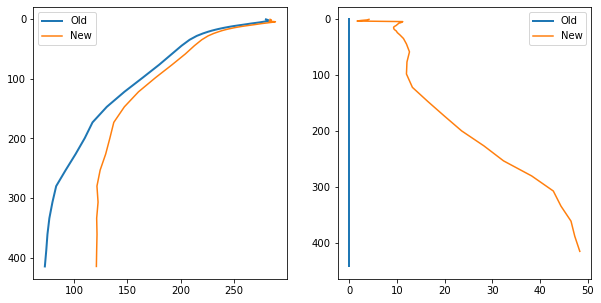

In [75]:
fig = profiles(tracer, file, d201905=True)

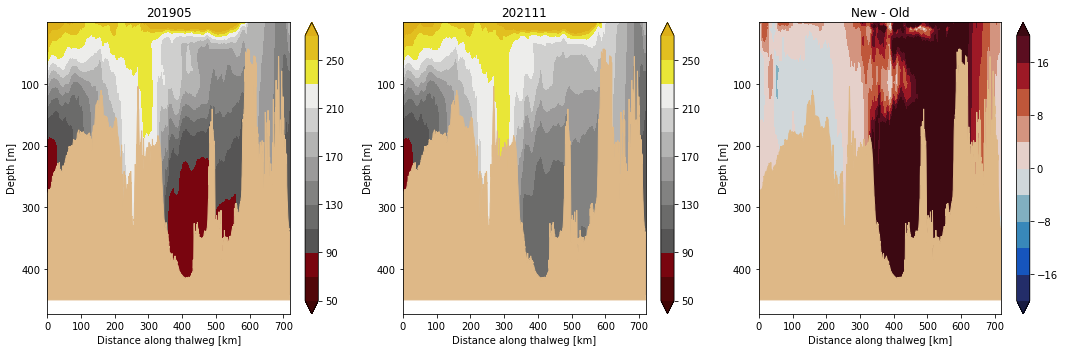

In [76]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

## YES ##

In [77]:
newdir = 'v201905r/'
year = 2007

### September PON ###

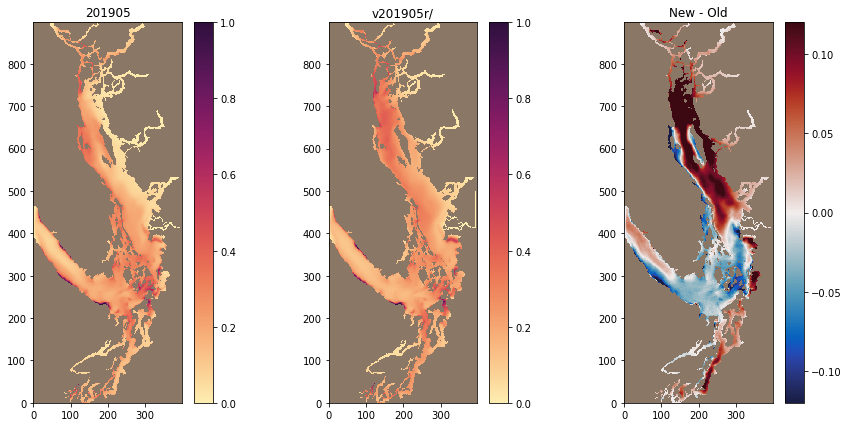

In [81]:
tracer = 'particulate_organic_nitrogen'
file = 'ptrc'
month = '09'
cmap = cm.matter
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.12 
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

0.5274103564364064 0.4976523249236947


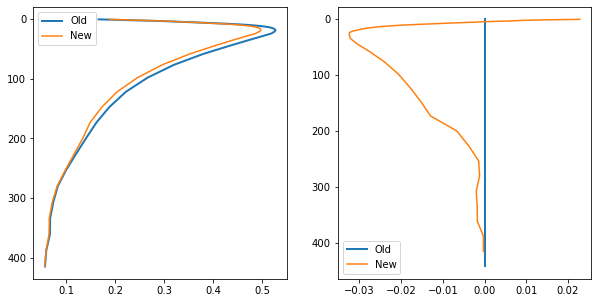

In [82]:
fig = profiles(tracer, file, d201905=True)

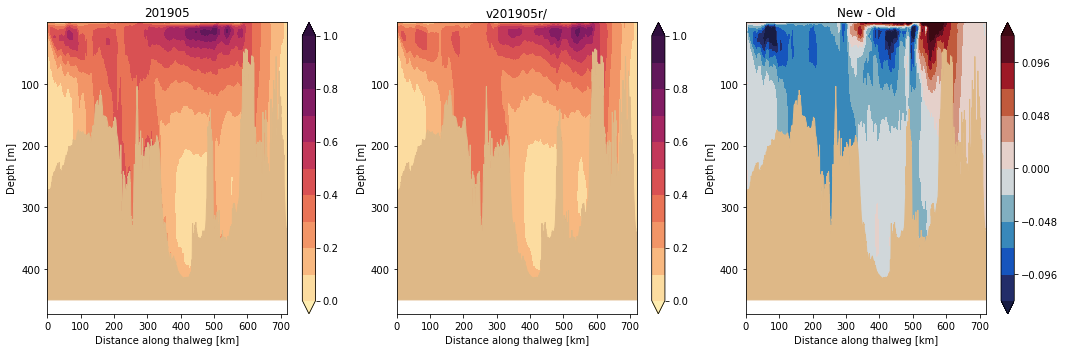

In [83]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### September DON ###

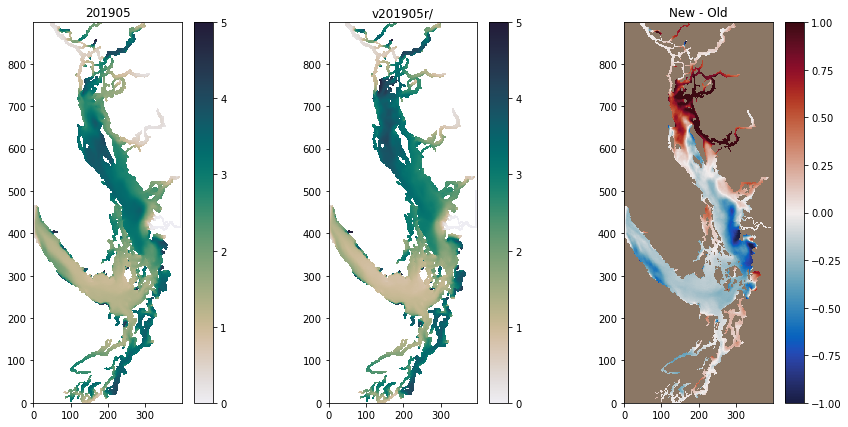

In [87]:
tracer = 'dissolved_organic_nitrogen'
file = 'ptrc'
month = '09'
cmap = cm.rain
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

2.1176734417361325 2.0242602075657397


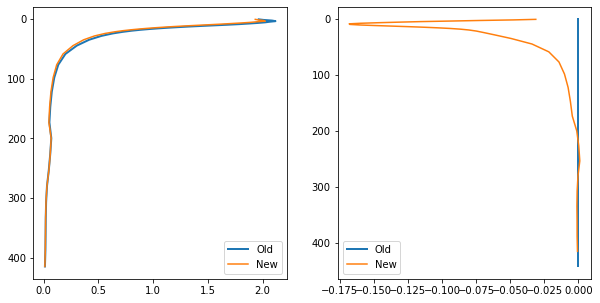

In [88]:
fig = profiles(tracer, file, d201905=True)

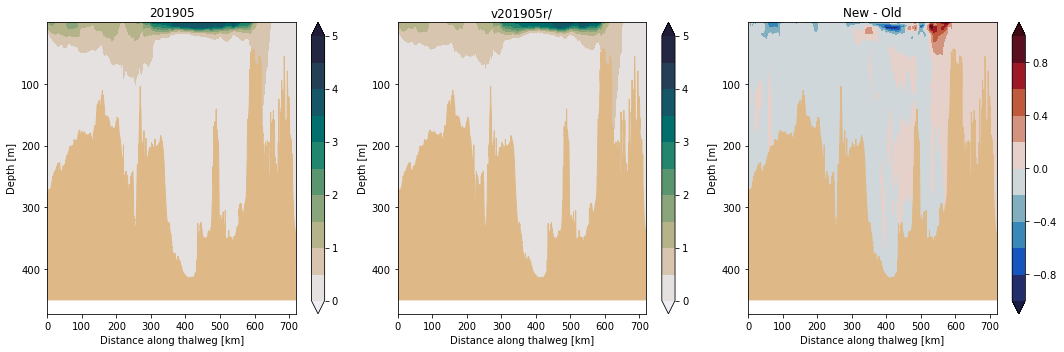

In [89]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### October Silicon ###

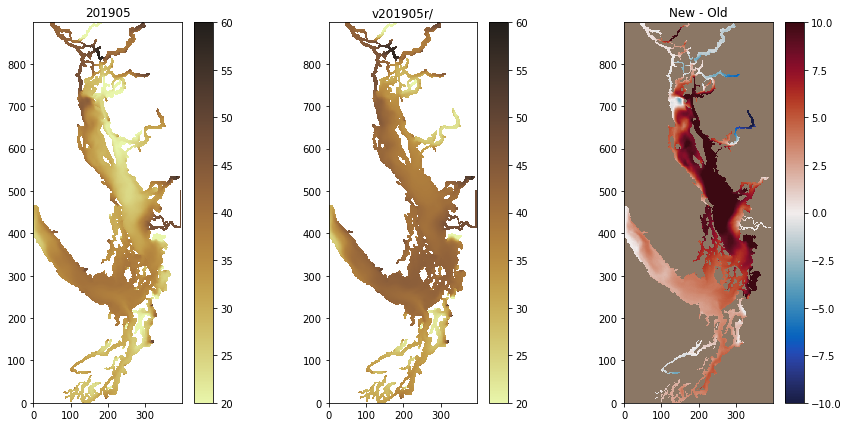

In [90]:
tracer = 'silicon'
file = 'ptrc'
month = '10'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 20
dvmax = 10
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

67.19903677142592 72.09916778015528


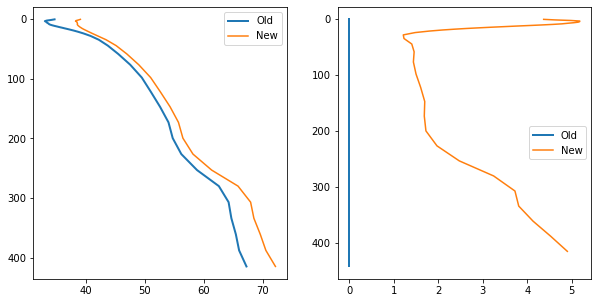

In [91]:
fig = profiles(tracer, file, d201905=True)

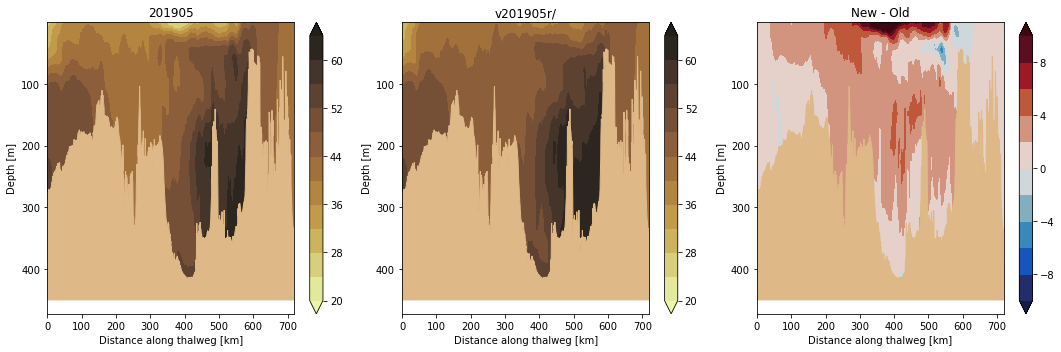

In [92]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### November DIC ###

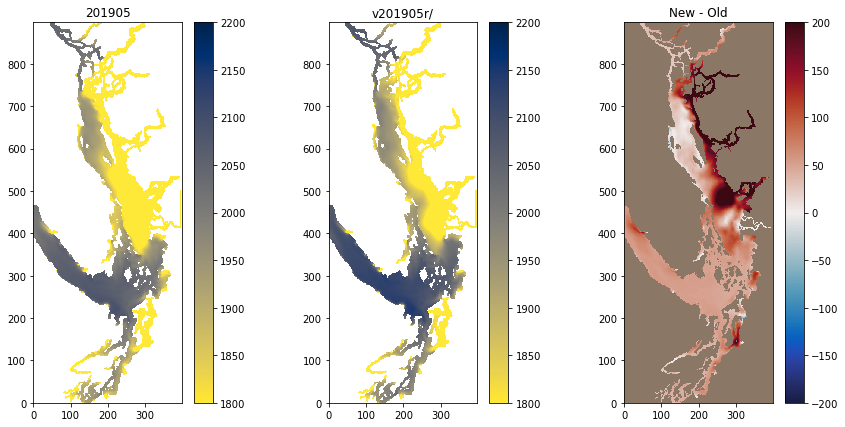

In [93]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
month = '11'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2200
vmin = 1800
dvmax = 200 
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

2137.540363531246 2185.8503648156084


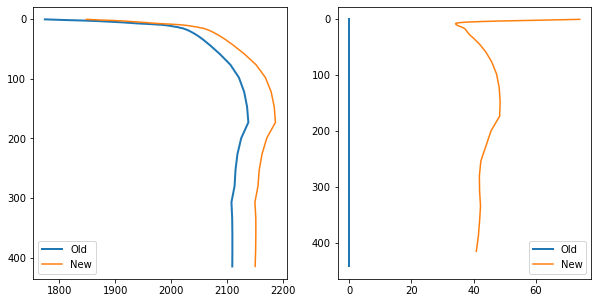

In [94]:
fig = profiles(tracer, file, d201905=True)

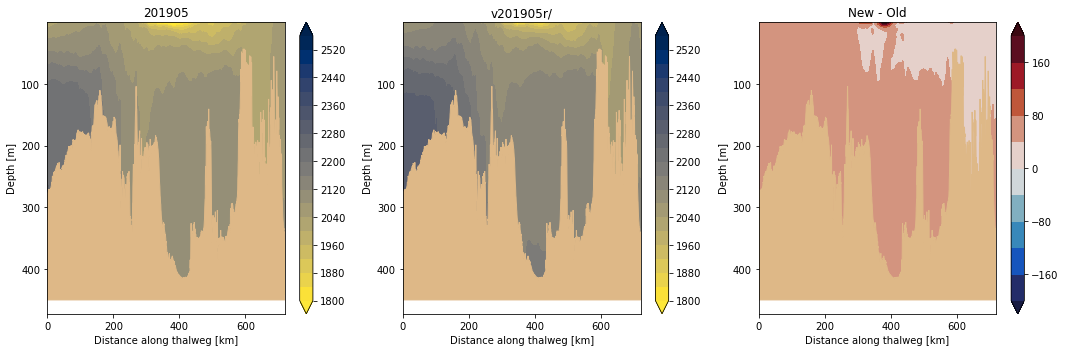

In [95]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### December Alkalinity ###

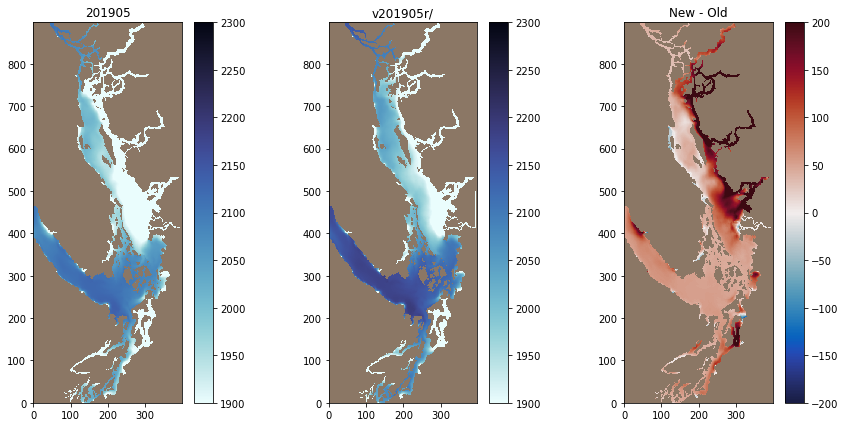

In [96]:
tracer = 'total_alkalinity'
file = 'carp'
month = '12'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 2300
vmin = 1900
dvmax = 200   
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

2166.3656486788605 2212.6216478118663


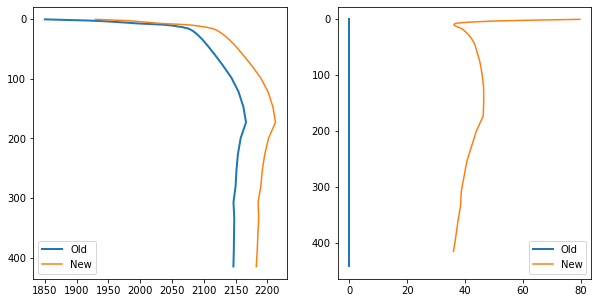

In [97]:
fig = profiles(tracer, file, d201905=True)

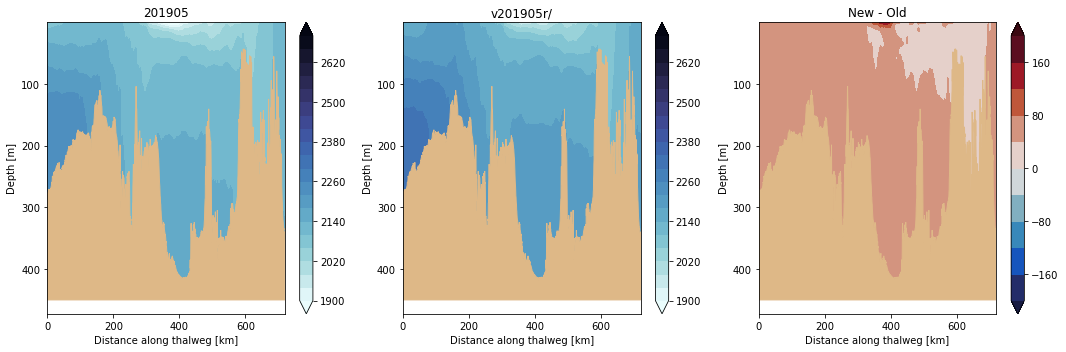

In [98]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

### Fraser Tracer ###

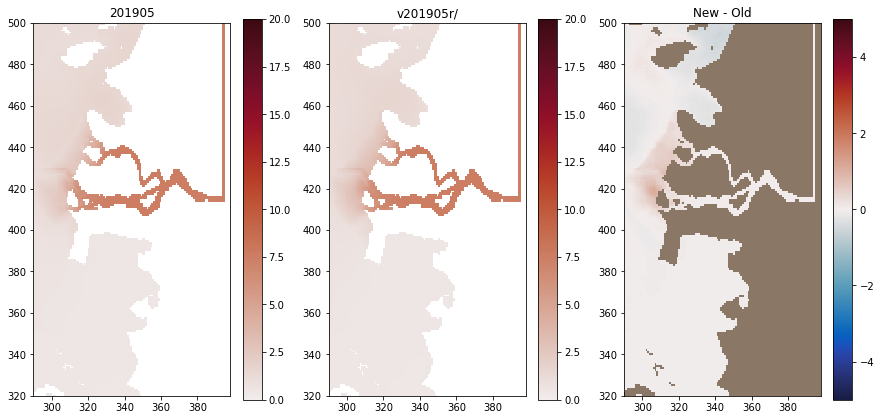

In [99]:
tracer = 'Fraser_tracer'
file = 'carp'
month = '12'
cmap = cm.amp
cdiff = cm.balance
vmax = 20
vmin = 0
dvmax = 5  
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, dl=3,
                    zoom=[320, 500, 290, 398], d201905=True)